In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from face_alignment import align
from backbones import get_model
import cv2
import os
import random
from collections import defaultdict

SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


# Model

In [2]:
class BaselineModel(nn.Module):
    def __init__(self, embed_dim=512, num_classes=7):
        super().__init__()

        model_name="edgeface_xxs"
        backbone = get_model(model_name)
        checkpoint_path = f'checkpoints/{model_name}.pt'
        backbone.load_state_dict(torch.load(checkpoint_path, map_location=device))

        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.backbone(x)
        return self.head(embeddings)

In [15]:
def build_image_dict(root="data"):
    all_image_dict = defaultdict(list)

    # duyệt: data/low_light/*/, data/normal/*/
    for split in os.listdir(root):
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            continue

        # mỗi split: low_light, normal
        for person in os.listdir(split_path):
            person_path = os.path.join(split_path, person)
            if not os.path.isdir(person_path):
                continue

            key = f"{split}"
            # key = f"{split}/{person}"

            # lấy toàn bộ ảnh trong thư mục người
            for f in os.listdir(person_path):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    all_image_dict[key].append(os.path.join(person_path, f))

    return all_image_dict

all_image_dict = build_image_dict("data")

for k, v in all_image_dict.items():
    print(k, len(v))

clahe_lighten_low_light 45
normal 43
low_light 45
darken_normal 129


In [18]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112,112)),   # tất cả ảnh phải đồng size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5]),
])

def get_embeddings(image_paths, bb):
    bb = bb.to(device)
    bb.eval()

    batch = []

    for image_path in image_paths:
        # aligned = align.get_aligned_face(image_path)

        # if aligned is None:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aligned = img

        aligned = np.asarray(aligned)   # đảm bảo ndarray
        x = transform(aligned)          # (3,112,112)
        batch.append(x)

    batch = torch.stack(batch).to(device)  # (N,3,112,112)
    print("Batch shape:", batch.shape)

    with torch.no_grad():
        emb = bb(batch)

    return emb

# get_embeddings(all_image_dict['normal/son']).shape

In [21]:
def draw_pca(model, class_to_paths: dict, save_path="pca_plot/pca_plot.png"):
    # 1. Lấy embedding cho từng class
    class_embeddings = {}
    for cls, paths in class_to_paths.items():
        if len(paths) == 0:
            continue
        print(f"Extracting embeddings for {cls} ({len(paths)} images)...")
        emb = get_embeddings(paths, model.backbone)   # ⬅️ dùng hàm mới
        class_embeddings[cls] = emb.cpu().numpy()           # (N, embed_dim)

    # 2. Ghép tất cả embedding
    all_embs = np.vstack(list(class_embeddings.values()))

    # 3. PCA -> 2D
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_embs)

    # 4. Tách lại theo class
    splitted = {}
    idx = 0
    for cls, emb in class_embeddings.items():
        n = emb.shape[0]
        splitted[cls] = emb_2d[idx:idx+n]
        idx += n

    # 5. Vẽ scatter
    plt.figure(figsize=(10, 8))
    for cls, pts in splitted.items():
        plt.scatter(pts[:, 0], pts[:, 1], label=cls, alpha=0.75, s=30)

    plt.legend()
    plt.title("PCA Projection of Face Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # 6. Lưu file
    os.makedirs('pca_plot', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_path = save_path.replace(".png", f"_{timestamp}.png")
    plt.savefig(final_path, dpi=300)
    plt.close()

    return final_path

model = BaselineModel()
all_image_dict = build_image_dict("data")
all_image_dict.pop('clahe_lighten_low_light')
all_image_dict.pop('darken_normal')
draw_pca(model, all_image_dict)

Extracting embeddings for normal (43 images)...
Batch shape: torch.Size([43, 3, 112, 112])
Extracting embeddings for low_light (45 images)...
Batch shape: torch.Size([45, 3, 112, 112])


'pca_plot/pca_plot_20251210_144653.png'

In [7]:
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        # 1. Load ảnh
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # img = np.asarray(img)

        # 3. Transform → tensor
        if self.transform is not None:
            img = self.transform(img)

        return img, label

def load_image_paths(trn_split_list, tst_split_list, root="data"):
    trn_paths = []
    trn_labels = []
    tst_paths = []
    tst_labels = []

    name_id_map = {}     # person -> id
    next_id = 0

    for split in trn_split_list:
        split_dir = os.path.join(root, split)
        if not os.path.isdir(split_dir):
            continue

        for person in os.listdir(split_dir):
            person_dir = os.path.join(split_dir, person)
            if not os.path.isdir(person_dir):
                continue

            # gán label id
            if person not in name_id_map:
                name_id_map[person] = next_id
                next_id += 1

            for f in os.listdir(person_dir):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    full_path = os.path.join(person_dir, f)
                    trn_paths.append(full_path)
                    trn_labels.append(name_id_map[person])

    for split in tst_split_list:
        split_dir = os.path.join(root, split)
        if not os.path.isdir(split_dir):
            continue

        for person in os.listdir(split_dir):
            person_dir = os.path.join(split_dir, person)
            if not os.path.isdir(person_dir):
                continue

            # gán label id
            if person not in name_id_map:
                name_id_map[person] = next_id
                next_id += 1

            for f in os.listdir(person_dir):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    full_path = os.path.join(person_dir, f)
                    tst_paths.append(full_path)
                    tst_labels.append(name_id_map[person])

    return trn_paths, trn_labels, tst_paths, tst_labels, name_id_map

def split_low_light(low_paths, low_labels, pct=0.1, seed=SEED):
    """pct = 0.1 → 10% val, 10% test. Còn lại train."""
    N = len(low_paths)
    np.random.seed(seed)
    idx = np.random.permutation(N)

    test_size = int(N * pct)
    val_size  = int(N * pct)

    test_idx = idx[:test_size]
    val_idx = idx[test_size:test_size+val_size]
    train_idx = idx[test_size+val_size:]

    low_train_paths = [low_paths[i] for i in train_idx]
    low_train_labels = [low_labels[i] for i in train_idx]

    low_val_paths = [low_paths[i] for i in val_idx]
    low_val_labels = [low_labels[i] for i in val_idx]

    low_test_paths = [low_paths[i] for i in test_idx]
    low_test_labels = [low_labels[i] for i in test_idx]

    return (low_train_paths, low_train_labels,
            low_val_paths, low_val_labels,
            low_test_paths, low_test_labels)

def build_dataloaders(trn_split_list, tst_split_list, root="data", pct=0.5, batch_size=8, shuffle=True):
    normal_paths, normal_labels, low_paths, low_labels, label_map = load_image_paths(trn_split_list, tst_split_list, root)

    (low_train_paths, low_train_labels,
     low_val_paths, low_val_labels,
     low_test_paths, low_test_labels) = split_low_light(low_paths, low_labels, pct)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((112,112)),   # tất cả ảnh phải đồng size
        transforms.Normalize(mean=[0.5,0.5,0.5],
                             std=[0.5,0.5,0.5]),
    ])
    # transform=None

    # train = normal + phần train của low_light
    train_ds = FaceDataset(
        normal_paths + low_train_paths,
        normal_labels + low_train_labels,
        transform=transform
    )

    val_ds = FaceDataset(
        low_val_paths, low_val_labels,
        transform=transform
    )

    test_ds = FaceDataset(
        low_test_paths, low_test_labels,
        transform=transform
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, label_map

trn_ld, val_ld, tst_ld, name_id_map = build_dataloaders(['normal'], ['low_light'], root="data", pct=0.5, batch_size=4)

print(len(trn_ld.dataset))
print(len(val_ld.dataset))
print(len(tst_ld.dataset))
print(name_id_map)

id_name_map = {v: k for k, v in name_id_map.items()}
# next(iter(trn_ld))

44
22
22
{'khanh': 0, 'tu': 1, 'minh': 2, 'lan': 3, 'dung': 4, 'son': 5, 'kien': 6}


4


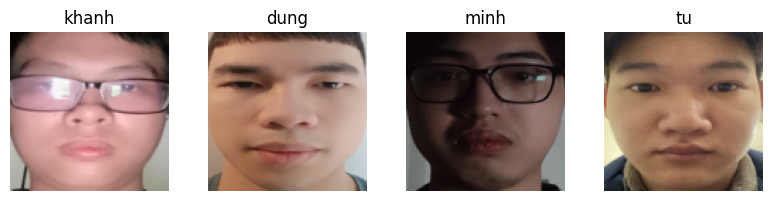

In [8]:
def unnormalize(img):
    img = img * 0.5 + 0.5   # từ [-1,1] về [0,1]
    return img.clip(0,1)

def show_first_batch(dataloader):
    imgs, labels = next(iter(dataloader))
    batch_size = imgs.size(0)
    print(batch_size)
    cols = 8
    rows = (batch_size + cols - 1) // cols
    
    plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(batch_size):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        img = unnormalize(img)
    
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(id_name_map[labels[i].item()])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_first_batch(trn_ld)

4


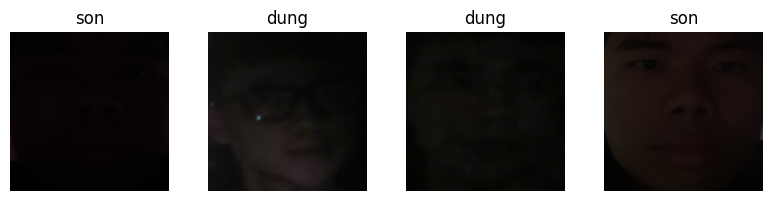

In [132]:
show_first_batch(tst_ld)

# Training

In [9]:
def eval_model(model, data_loader, id_name_map, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    # overall
    correct = 0
    total = 0
    running_loss = 0.0

    # per-class
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            pred = logits.argmax(dim=1)

            # Loss
            loss = criterion(logits, labels)
            running_loss += loss.item()

            # overall
            # print('Pred:', pred)
            # print('Label:', labels)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

            # per-class
            for l, p in zip(labels, pred):
                class_total[l.item()] += 1
                if l == p:
                    class_correct[l.item()] += 1

    # convert to accuracy per class
    class_acc = {}
    for label in class_total:
        acc = class_correct[label] / class_total[label]
        class_acc[id_name_map[label]] = acc

    overall_acc = correct / total
    val_loss = running_loss / len(data_loader)

    return val_loss, overall_acc, class_acc

def train(model, train_loader, val_loader, id_name_map,
          lr=1e-3, num_epochs=10, unfreeze_epoch=3,
          patience=3, device="cuda"):

    # ----- 0) Early stopping state -----
    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None

    # ----- 1) Freeze backbone lúc đầu -----
    for p in model.backbone.parameters():
        p.requires_grad = False

    optimizer = torch.optim.Adam(model.head.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(num_epochs):

        # ----- 2) Unfreeze backbone -----
        if epoch == unfreeze_epoch:
            print(f"=== Unfreezing backbone at epoch {epoch} ===")

            for p in model.backbone.parameters():
                p.requires_grad = True

            optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.5)

        # ----------------- Training -----------------
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # ----------------- Validation ----------------
        val_loss, overall_acc, class_acc = eval_model(model, val_loader, id_name_map)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {running_loss/len(train_loader):.4f} "
              f"Val Loss: {val_loss:.4f}")
        print("Overall accuracy:", overall_acc)

        for cls, acc in class_acc.items():
            print(f"{cls}: {acc:.4f}")

        # ----- 3) EARLY STOPPING -----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()  # save best weights
        else:
            patience_counter += 1
            print(f"✗ No improvement. Patience {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("⛔ Early stopping triggered!")
                break

    print("Restoring best model weights...")
    model.load_state_dict(best_state)
    return model

In [83]:
model = BaselineModel(512, len(name_id_map))
model = train(model, trn_ld, val_ld, id_name_map, num_epochs=30, unfreeze_epoch=5)

[Epoch 1/30] Train Loss: 1.9029 Val Loss: 1.8913
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
✓ Val loss improved inf → 1.8913
[Epoch 2/30] Train Loss: 1.7073 Val Loss: 1.8281
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
✓ Val loss improved 1.8913 → 1.8281
[Epoch 3/30] Train Loss: 1.4784 Val Loss: 1.7588
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
✓ Val loss improved 1.8281 → 1.7588
[Epoch 4/30] Train Loss: 1.2007 Val Loss: 1.6864
Overall accuracy: 0.2727272727272727
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
✓ Val loss improved 1.7588 → 1.6864
[Epoch 5/30] Train Loss: 0.9610 Val Loss: 1.6231
Overall accuracy: 0.3181818181818182
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
ki

In [85]:
eval_model(model, tst_ld, id_name_map)

(1.458524723847707,
 0.5454545454545454,
 {'son': 0.25,
  'dung': 0.5714285714285714,
  'tu': 0.75,
  'minh': 1.0,
  'lan': 0.0})

# Synthetic Data
## Darken

In [95]:
def dark_augment(img):
    h, w = img.shape[:2]
    aug = img.copy()

    # Gamma cực thấp để tối mạnh
    gamma = random.uniform(0.15, 0.35)
    inv_gamma = 1.0 / gamma
    table = (np.array([((i / 255.0) ** inv_gamma) * 255
                       for i in np.arange(256)])).astype("uint8")
    aug = cv2.LUT(aug, table)

    # Giảm brightness mạnh
    brightness_factor = random.uniform(0.2, 0.4)
    aug = np.clip(aug * brightness_factor, 0, 255).astype(np.uint8)

    # 3. Noise nhẹ (ISO vừa)
    noise_std = random.randint(3, 8)   # nhẹ, không phá mặt
    noise = np.random.normal(0, noise_std, (h, w, 3))
    aug = np.clip(aug + noise, 0, 255).astype(np.uint8)

    # 4. Blur nhẹ (tùy chọn)
    aug = cv2.GaussianBlur(aug, (3, 3), 0)

    # Color shift vàng nhẹ (tự nhiên)
    shift_b = random.randint(-10, -3)    # giảm Blue nhẹ
    aug[..., 0] = np.clip(aug[..., 0] + shift_b, 0, 255)

    shift_r = random.randint(3, 10)      # tăng Red nhẹ
    aug[..., 2] = np.clip(aug[..., 2] + shift_r, 0, 255)

    if random.random() < 0.5:
        aug = cv2.flip(aug, 1)

    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (w, h), 
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)

    return aug

def save_augment_images(augment_func, num_augs_for_each, target_dir, save_dir, show_im=False):
    for img_path in all_image_dict[target_dir]:
        image = cv2.imread(img_path)
        for i in range(num_augs_for_each):
            processed_img = augment_func(image)
        
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        
            img_name = f"{img_path.split('/')[-2]}/{i}-{img_path.split('/')[-1]}"
            os.makedirs(f"data/{save_dir}/{img_path.split('/')[-2]}", exist_ok=True)
            cv2.imwrite(f'data/{save_dir}/{img_name}', processed_img)
            # print(f'Successfully write data/{save_dir}/{img_name}')
            
            if show_im:
                plt.figure(figsize=(8,4))
            
                plt.subplot(1, 2, 1)
                plt.imshow(img_rgb)
                plt.title(img_path)
                plt.axis("off")
            
                plt.subplot(1, 2, 2)
                plt.imshow(processed_rgb)
                plt.title(img_path)
                plt.axis("off")
            
                plt.show()

    print('Success')

save_augment_images(dark_augment, 3, 'normal', 'darken_normal') 

Success


## CLAHE Lighten

In [94]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

save_augment_images(apply_clahe, 1, 'low_light', 'clahe_lighten_low_light')

Success


In [96]:
new_image_dict = build_image_dict('data')
for k, v in new_image_dict.items():
    print(k, len(v))

new_image_dict.pop('clahe_lighten_low_light')
draw_pca(new_image_dict)

clahe_lighten_low_light 45
normal 43
low_light 45
darken_normal 129
Extracting embeddings for normal (43 images)...
Batch shape: torch.Size([43, 3, 112, 112])
Extracting embeddings for low_light (45 images)...
Batch shape: torch.Size([45, 3, 112, 112])
Extracting embeddings for darken_normal (129 images)...
Batch shape: torch.Size([129, 3, 112, 112])


'pca_plot_20251210_103944.png'

In [10]:
trn_ld, val_ld, tst_ld, name_id_map = build_dataloaders(['normal', 'darken_normal'], ['low_light'], root="data", pct=0.5, batch_size=8)

print(len(trn_ld.dataset))
print(len(val_ld.dataset))
print(len(tst_ld.dataset))
print(name_id_map)
id_name_map = {v: k for k, v in name_id_map.items()}

173
22
22
{'khanh': 0, 'tu': 1, 'minh': 2, 'lan': 3, 'dung': 4, 'son': 5, 'kien': 6}


8


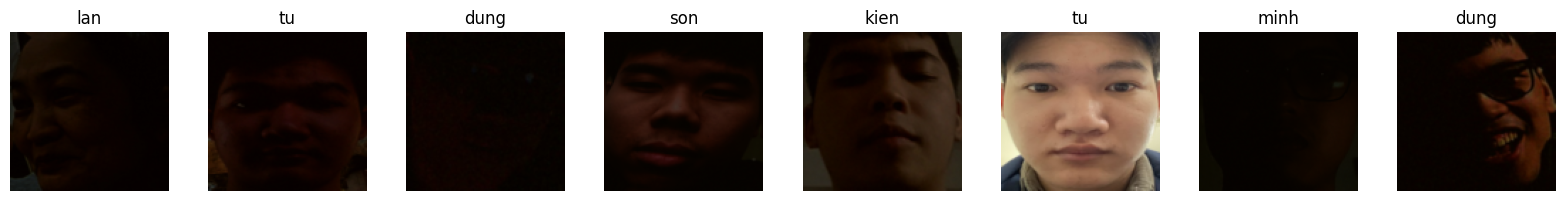

In [119]:
show_first_batch(trn_ld)

8


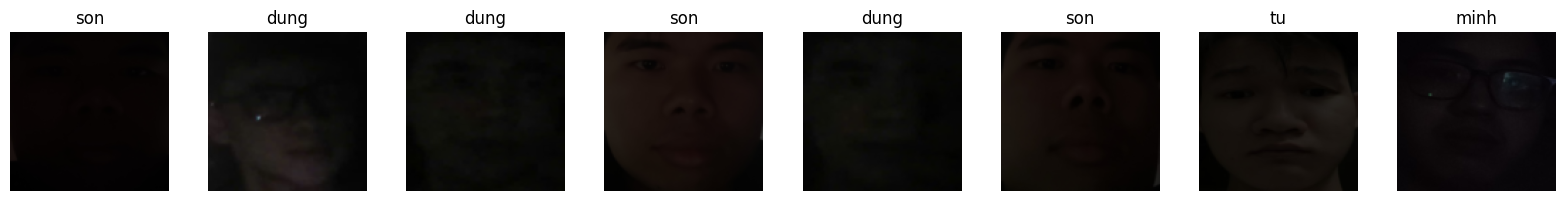

In [120]:
show_first_batch(tst_ld)

In [121]:
model = BaselineModel(512, len(name_id_map))
model = train(model, trn_ld, val_ld, id_name_map, num_epochs=30)

[Epoch 1/30] Train Loss: 1.8358 Val Loss: 1.8496
Overall accuracy: 0.18181818181818182
dung: 0.0000
khanh: 0.0000
tu: 0.2500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 0.0000
[Epoch 2/30] Train Loss: 1.4382 Val Loss: 1.7851
Overall accuracy: 0.3181818181818182
dung: 0.0000
khanh: 0.0000
tu: 0.7500
minh: 1.0000
son: 0.0000
lan: 0.0000
kien: 1.0000
[Epoch 3/30] Train Loss: 0.9657 Val Loss: 1.7649
Overall accuracy: 0.3181818181818182
dung: 0.1429
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
=== Unfreezing backbone at epoch 3 ===
[Epoch 4/30] Train Loss: 0.6746 Val Loss: 1.8366
Overall accuracy: 0.3181818181818182
dung: 0.1429
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
✗ No improvement. Patience 1/3
[Epoch 5/30] Train Loss: 0.5423 Val Loss: 1.8268
Overall accuracy: 0.4090909090909091
dung: 0.4286
khanh: 0.0000
tu: 0.7500
minh: 0.6667
son: 0.0000
lan: 0.0000
kien: 1.0000
✗ No improvement. Patience 2/3
[Epoch 6/30] Train Loss: 0.4

In [122]:
eval_model(model, tst_ld, id_name_map)

(1.7922042608261108,
 0.3181818181818182,
 {'son': 0.25,
  'dung': 0.2857142857142857,
  'tu': 0.75,
  'minh': 0.25,
  'lan': 0.0})

# Our method
## Model

In [11]:
class ContrastiveBackbone(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()

        model_name = "edgeface_xxs"
        backbone = get_model(model_name)
        checkpoint_path = f"checkpoints/{model_name}.pt"
        backbone.load_state_dict(torch.load(checkpoint_path, map_location=device))

        self.backbone = backbone

    def forward(self, x1, x2):
        z1 = self.backbone(x1)
        z2 = self.backbone(x2)
        return z1, z2

## Augment ảnh sáng vẫn rõ mặt

In [58]:
def light_augment(img):
    h, w = img.shape[:2]
    out = img.copy()

    # ---- 1) CLAHE nhẹ (tăng local contrast nhưng giữ brightness) ----
    lab = cv2.cvtColor(out, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    out = cv2.cvtColor(cv2.merge([l2, a, b]), cv2.COLOR_LAB2BGR)

    # ---- 2) Vignette rất nhỏ (giảm viền 5–10%) ----
    if random.random() < 0.5:
        kernel_x = cv2.getGaussianKernel(w, w/2)
        kernel_y = cv2.getGaussianKernel(h, h/2)
        mask = kernel_y @ kernel_x.T
        mask = mask / mask.max()
        mask = 0.9 + 0.1 * mask  # nổi bật trung tâm nhưng rất nhẹ
        vignette = (out * mask[..., None]).astype(np.uint8)
        out = vignette

    # ---- 3) Light spot (tăng sáng vùng nhỏ, không đổi global brightness) ----
    if random.random() < 0.5:
        cx = random.randint(w//4, 3*w//4)
        cy = random.randint(h//4, 3*h//4)
        radius = random.randint(int(0.2*min(h,w)), int(0.4*min(h,w)))

        Y, X = np.ogrid[:h, :w]
        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        mask = 1 + 0.15 * np.clip(1 - dist/radius, 0, 1)  # +15% sáng vùng đó
        light = np.clip(out * mask[..., None], 0, 255).astype(np.uint8)
        out = light

    # ---- 4) Shadow nhẹ (không quá 10–15%) ---
    if random.random() < 0.5:
        x1 = random.randint(0, w//2)
        y1 = random.randint(0, h//2)
        x2 = random.randint(w//2, w)
        y2 = random.randint(h//2, h)

        shadow_mask = np.zeros((h, w), dtype=np.float32)
        cv2.rectangle(shadow_mask, (x1, y1), (x2, y2), 1, -1)
        shadow_mask = cv2.GaussianBlur(shadow_mask, (99, 99), 30)
        shadow = 1 - 0.15 * shadow_mask  # giảm sáng tối đa 15%

        out = np.clip(out * shadow[..., None], 0, 255).astype(np.uint8)

    if random.random() < 0.5:
        out = cv2.flip(out, 1)

    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        out = cv2.warpAffine(out, M, (w, h), 
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)

    return out

save_augment_images(light_augment, 3, 'normal', 'augment_normal')

Success


## Pretrain Dataloader

In [12]:
class PairedLightDarkDataset(Dataset):
    def __init__(self, light_map, dark_map):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],
                                 std=[0.5,0.5,0.5]),
        ])

        # 1) gom ảnh theo ID người
        self.light_map = light_map  # id → list of images
        self.dark_map = dark_map

        # 2) chỉ lấy các id xuất hiện trong cả sáng và tối
        self.person_ids = [
            pid for pid in self.light_map.keys()
            if pid in self.dark_map
        ]

        if len(self.person_ids) == 0:
            raise ValueError("❌ Không có ID nào xuất hiện ở cả ảnh sáng và tối!")

    def __len__(self):
        return len(self.person_ids)

    def __getitem__(self, idx):
        pid = self.person_ids[idx]

        # random 1 ảnh sáng và 1 ảnh tối của cùng người
        light_path = random.choice(self.light_map[pid])
        dark_path  = random.choice(self.dark_map[pid])

        img_light = cv2.imread(light_path)
        img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2RGB)
        img_dark  = cv2.imread(dark_path)
        img_dark = cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB)

        if self.transform:
            img_light = self.transform(img_light)
            img_dark  = self.transform(img_dark)

        return img_light, img_dark

light_paths, light_ids, dark_paths, dark_ids, _ = load_image_paths(['normal'], ['darken_normal'])

light_map = defaultdict(list)
dark_map = defaultdict(list)
for id, path in zip(light_ids, light_paths):
    light_map[id].append(path)
for id, path in zip(dark_ids, dark_paths):
    dark_map[id].append(path)

pretrn_ds = PairedLightDarkDataset(light_map, dark_map)
pretrn_ld = DataLoader(pretrn_ds, batch_size=4, shuffle=True)

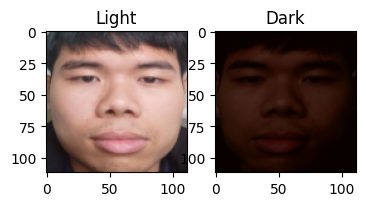

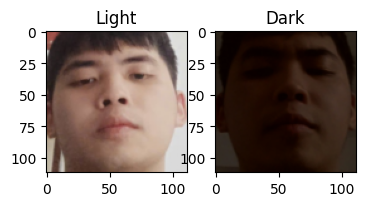

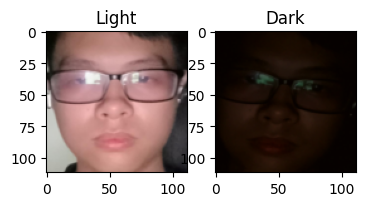

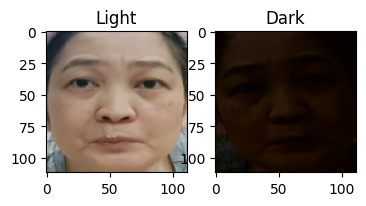

In [13]:
batch = next(iter(pretrn_ld))
x_light, x_dark = batch

for i in range(4):
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow(unnormalize(x_light[i]).permute(1,2,0))
    plt.title("Light")

    plt.subplot(1,2,2)
    plt.imshow(unnormalize(x_dark[i]).permute(1,2,0))
    plt.title("Dark")
    plt.show()

In [14]:
def pretrain(model, pretrn_ld, num_epochs=5, lr=1e-4, device="cuda"):
    model = model.to(device)

    cos = nn.CosineSimilarity(dim=1)
    optimizer = torch.optim.Adam(model.backbone.parameters(), lr=lr)

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for x_light, x_dark in pretrn_ld:
            x_light = x_light.to(device)
            x_dark  = x_dark.to(device)

            # forward pair
            z1, z2 = model(x_light, x_dark)

            # contrastive loss: want them close
            loss = 1 - cos(z1, z2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"🔹 Epoch {epoch+1}: avg loss = {total_loss/len(pretrn_ld):.4f}")

    print("🎉 Pretrain hoàn tất!")
    return model

model_bb = ContrastiveBackbone()
model_bb = pretrain(model_bb, pretrn_ld)

loss: 0.6594
loss: 0.2158
🔹 Epoch 1: avg loss = 0.4376
loss: 0.0711
loss: 0.0894
🔹 Epoch 2: avg loss = 0.0803
loss: 0.0090
loss: 0.0046
🔹 Epoch 3: avg loss = 0.0068
loss: 0.0029
loss: 0.0019
🔹 Epoch 4: avg loss = 0.0024
loss: 0.0018
loss: 0.0018
🔹 Epoch 5: avg loss = 0.0018
🎉 Pretrain hoàn tất!


## New PCA

In [22]:
all_image_dict = build_image_dict("data")
all_image_dict.pop('clahe_lighten_low_light')
all_image_dict.pop('darken_normal')

draw_pca(model_bb, all_image_dict)

Extracting embeddings for normal (43 images)...
Batch shape: torch.Size([43, 3, 112, 112])
Extracting embeddings for low_light (45 images)...
Batch shape: torch.Size([45, 3, 112, 112])


'pca_plot/pca_plot_20251210_144734.png'

In [ ]:
class ContrastiveModel(nn.Module):
    def __init__(self, pretrained_backbone, embed_dim=512, num_classes=100, freeze_backbone=False):
        super().__init__()

        # lấy backbone đã pretrain
        self.backbone = pretrained_backbone.backbone

        # freeze nếu bạn muốn (khuyên: unfreeze 1–2 layer cuối)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        layers = list(model.children())

        #   Bật grad cho n layer cuối
        for layer in layers[-n:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.backbone(x)
        return self.head(embeddings)